In [1]:
import matplotlib.pyplot as plt
#import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np


In [2]:
from google.cloud import bigquery


In [3]:
client = bigquery.Client.from_service_account_json(
    "../../gcloud/hypothermia-auth.json"
)

In [4]:
def generate_histogram_query(project, neonate, n_bins, distance, limit):
    histogram_query = """
    WITH head_data AS (
        SELECT {distance}
        FROM
          `{project}.neo_desat.{neonate}`
        ORDER BY
          {distance} ASC
        LIMIT
          {limit}
        )
        
    SELECT
      MIN(data.{distance}) AS min,
      MAX(data.{distance}) AS max,
      COUNT(data.{distance}) AS num,
      CAST((data.{distance}-value.min)/(value.max-value.min)*{n_bins} AS INT64)   AS group_
    FROM
      head_data data
    CROSS JOIN (
      SELECT
        MAX({distance}) AS max,
        MIN({distance}) AS min
      FROM
        head_data) value
    GROUP BY
      group_
    ORDER BY
      group_
    """.format(neonate=neonate, n_bins=n_bins, distance=distance, project=project, limit=limit)
    return histogram_query


In [5]:
def plot_errors(x, y , **kwargs):
        
    sns.lineplot(x,y, **kwargs)
    plt.fill_between(x,y, **kwargs)

FIGPATH = '/home/buck06191/Dropbox/phd/desat_neonate/ABC/Figures/'
def error_distributions(limit=1000000):
    neonates = ['neo007', 'neo021']
    df_list = []
    for NEONATE in neonates:
        query = generate_histogram_query('hypothermia-bayescmd',
                                         NEONATE,
                                         limit/100,
                                         'NRMSE',
                                         limit)
        df_temp = client.query(query).to_dataframe()
        df_temp['log_min'] = np.log10(df_temp['min'].values)
        df_temp['cumnum'] = df_temp.num.cumsum()
        df_temp['Neonate'] = NEONATE
        df_list.append(df_temp)


    df = pd.concat(df_list)
    aspect=2
    sns.set_context('paper', 1.25)
    sns.set_style('whitegrid')
    
    if limit>=10000000:
        g = sns.FacetGrid(data=df, hue='Neonate', sharey=True, sharex=False, aspect=aspect, height=7/aspect) 
        # g.fig.axes[0].ticklabel_format(style='plain', axis='y')
    else:
        g = sns.FacetGrid(data=df, row='Neonate', hue='Neonate', sharey=True, sharex=False, aspect=aspect, height=7/aspect)        
    g = (g.map(plot_errors, 'min', 'cumnum', alpha=0.5).add_legend(fontsize=14))

    if df['min'].max() > 10:
        g.fig.axes[0].set_xscale('log')
    g.set_ylabels('Cumulative count')
    g.set_xlabels('NRMSE')

#     for ax  in g.fig.axes:
#         ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

    plt.setp(g._legend.get_title(), fontsize=16)


    g.savefig(FIGPATH+"error_dist_{}.png".format(limit), dpi=350, bbox_inches='tight')
    return g

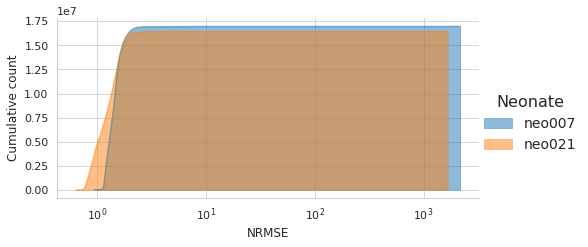

In [6]:
error_distributions(20000000)

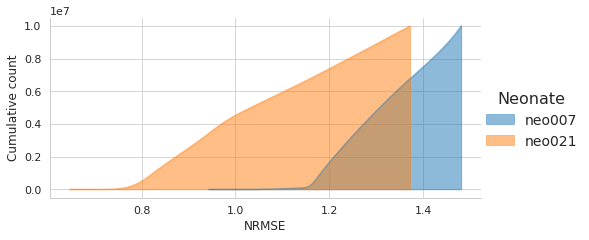

In [7]:
error_distributions(10000000)

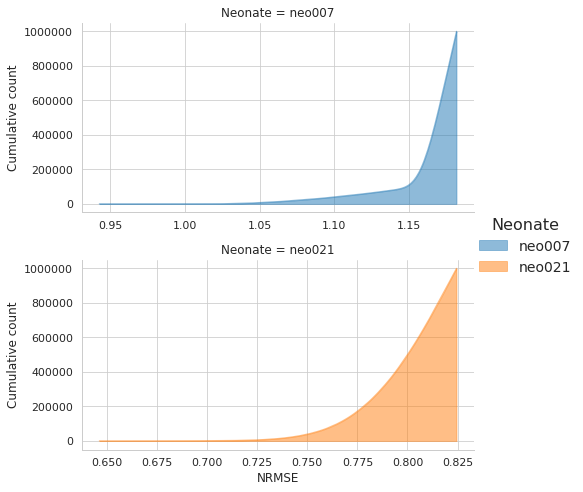

In [8]:
error_distributions(1000000)

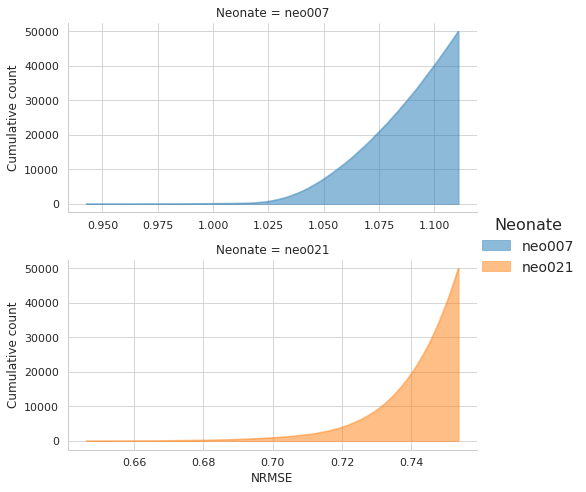

In [9]:
error_distributions(50000)